## Flame Image Classifier
---

* The objective of this project is to develop a neural network-based model capable of classifying images of flames into three categories: ethanol, pentane, and propanol. 

* This classification task is crucial for understanding the characteristics and properties of different types of flames, which has practical applications in fields like fire safety, combustion research, and material testing. 

* The project utilizes the ResNet-34 architecture, a pre-trained model, and leverages transfer learning to the specific task of flame classification.

### Import Libraries
---

In [2]:
# libraries from PyTorch for neural network
import torchvision
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision import transforms
import torch.nn.functional as F

# libraries for preprocessing and evaluating the model
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix,  precision_recall_curve
from sklearn.preprocessing import label_binarize

# library for numerical operations
import numpy as np

# libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc
from itertools import cycle

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preprocessing and Augmentation
---
1. RandomResizedCrop: This randomly crops and resizes the images to a specified size (in our case, 224x224 pixels). This is important for two reasons: it ensures that all images fed into the neural network are of uniform size, and it introduces variability in the dataset by showing different parts of the images each time, which helps prevent overfitting.
2. RandomHorizontalFlip: This randomly flips the images horizontally with a given probability (50% in the code). This again introduces variability into the dataset, simulating different viewing angles and further helping to prevent overfitting.
3. Normalize: This normalizes the pixel values of the images using the specified mean and standard deviation. Normalization is a common practice in image processing for neural networks; it makes the training process smoother and more stable.
4. RandomRotation: This would randomly rotate the images by up to a specified angle, introducing more variability and robustness to the model.

In [3]:
# Define transforms for the input data
transform = torchvision.transforms.Compose([
    # Randomly crops and resizes images to 224x224 pixels, with anti-aliasing.
    torchvision.transforms.RandomResizedCrop((224, 224), antialias=True),
    # Converts images to PyTorch tensors.
    torchvision.transforms.ToTensor(),
    # Applies horizontal flip to images with a probability of 50%.
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # Normalizes images using precomputed mean and std.
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ## Randomly rotates images by up to 10 degrees.
    # transforms.RandomRotation(10),
])

### Load the Dataset (and Apply the Transformations)
---

In [4]:
# Define the path to the dataset
dataset_path = './data'

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)

### Splitting the dataset into training, validation, and testing sets
---

In [5]:
# Splitting the dataset into training, validation, and testing sets
train_size = int(0.60 * len(dataset))  # Allocates 60% of the dataset for training.
val_size = int(0.20 * len(dataset))  # # Allocates 20% of the dataset for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing (%20)

# Randomly splitting the dataset into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Print the sizes of each dataset
print(f"Training Dataset: {len(train_dataset)}")
print(f"Validation Dataset: {len(val_dataset)}")
print(f"Testing Dataset: {len(test_dataset)}")

Training Dataset: 1800
Validation Dataset: 600
Testing Dataset: 600


### Load the Pre-trained Model ResNet-34
---
1. Loads a pre-trained ResNet-34 model and customizes it for the flame image classification task.
2. This model is pre-trained on ImageNet, a large dataset with a wide variety of images. Using a pre-trained model helps in leveraging the knowledge gained from a larger dataset, which can improve performance even with a smaller dataset like ours.

In [6]:
# Importing necessary components for the neural network
# import torch.nn as nn
# from torchvision.models import resnet34

# The URL provided (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
# is a reference to the source code of the ResNet model in the torchvision package.

# Define the number of classes for the classification task
num_classes = 3

# Load the pre-trained ResNet-34 model
model = resnet34(pretrained=True)

# Modify the final layer of the ResNet-34 model
model.fc = nn.Linear(model.fc.in_features, num_classes)
# The original fully connected (fc) layer is replaced with a new one where the output features 
# match the number of classes. This modification tailors the model to output predictions for 
# three classes instead of the original 1000 classes used in ImageNet.


/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Model Fine-Tuning and Training Setup
---
This section involves fine-tuning the pre-trained ResNet-34 model with the custom flame dataset.


In [7]:
# Freezing the pre-trained layers of the model
for param in model.parameters():
    param.requires_grad = False
# This loop sets 'requires_grad' to False for all parameters, effectively freezing them.
# As a result, these parameters will not be updated during training, preserving the learned features.


# Unfreezing the newly added classification layer
for param in model.fc.parameters():
    param.requires_grad = True
# Only the parameters of the final classification layer are left trainable.
# This allows the model to learn from the new dataset specifically for the classification task.


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Cross-entropy loss is commonly used for classification tasks.
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
# The optimizer is configured to update only the parameters of the final layer.

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# This scheduler adjusts the learning rate based on the number of epochs,
# which can help improve training efficiency and prevent overfitting.

#### Define Batch size

In [8]:
# Define batch size
batch_size = 100 

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for training data.
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # DataLoader for validation data.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # DataLoader for testing data.
# Data loaders are used to efficiently load data in batches and optionally shuffle it for training.

# Note: Experimenting with different learning rates, batch sizes, and training epochs is suggested to optimize the model's performance.

### Model Training (with Progressive Layer Unfreezing)
---

In [28]:
# Training and Fine-tuning the Model

# Define a function to train and fine-tune the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    unfreeze_steps = 3  # The number of steps to progressively unfreeze layers
    total_layers = len(list(model.children())) # Total number of layers in the model
    layers_to_unfreeze_per_step = total_layers // unfreeze_steps # Layers to unfreeze in each step


    # Initialize lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Calculate the current unfreezing step based on the epoch
        current_step = epoch // (num_epochs // unfreeze_steps)

        # Get the layers of the model
        children = list(model.children())

        # Determine the layers to unfreeze in this step
        layers_to_unfreeze = children[-(current_step * layers_to_unfreeze_per_step):]

        # Flag to check if any layer was unfrozen in this epoch
        flag_layers_unfrozen = False

        # Unfreezing the selected layers
        for child in layers_to_unfreeze:
            for param in child.parameters():
                if not param.requires_grad:
                    param.requires_grad = True # Unfreeze the layer
                    flag_layers_unfrozen = True

        # Reinitialize the optimizer if any layer was unfrozen, to include the newly unfrozen parameters
        if flag_layers_unfrozen:
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        
        # Training phase
        model.train() # Set the model to training mode
        train_loss = 0
        train_corrects = 0

        # Iterate over the training dataset
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval() # Set the model to evaluation mode
        val_loss = 0
        val_corrects = 0

        # Iterate over the validation dataset
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Compute validation loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_corrects.double() / len(val_loader.dataset)


        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print training and validation results for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [29]:
# Call the function
model, train_losses, val_losses, train_accuracies, val_accuracies  = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

Epoch 1/20
Train Loss: 0.3841 Acc: 0.8372
Val Loss: 0.7984 Acc: 0.7100
Epoch 2/20
Train Loss: 0.1708 Acc: 0.9306
Val Loss: 0.1678 Acc: 0.9367
Epoch 3/20
Train Loss: 0.1038 Acc: 0.9650
Val Loss: 0.0951 Acc: 0.9700
Epoch 4/20
Train Loss: 0.0838 Acc: 0.9700
Val Loss: 0.2178 Acc: 0.8983
Epoch 5/20
Train Loss: 0.1009 Acc: 0.9672
Val Loss: 0.0585 Acc: 0.9783
Epoch 6/20
Train Loss: 0.0842 Acc: 0.9683
Val Loss: 0.3282 Acc: 0.8833
Epoch 7/20
Train Loss: 0.0859 Acc: 0.9672
Val Loss: 0.2151 Acc: 0.9233
Epoch 8/20
Train Loss: 0.0689 Acc: 0.9717
Val Loss: 0.1293 Acc: 0.9483
Epoch 9/20
Train Loss: 0.0534 Acc: 0.9806
Val Loss: 0.1157 Acc: 0.9500
Epoch 10/20
Train Loss: 0.0507 Acc: 0.9800
Val Loss: 0.0852 Acc: 0.9667
Epoch 11/20
Train Loss: 0.0616 Acc: 0.9783
Val Loss: 0.0773 Acc: 0.9650
Epoch 12/20
Train Loss: 0.0591 Acc: 0.9794
Val Loss: 0.0573 Acc: 0.9783
Epoch 13/20
Train Loss: 0.0469 Acc: 0.9839
Val Loss: 0.1415 Acc: 0.9533
Epoch 14/20
Train Loss: 0.0381 Acc: 0.9872
Val Loss: 0.1299 Acc: 0.9433
E

#### Training and Validation Loss/Accuracy Curves

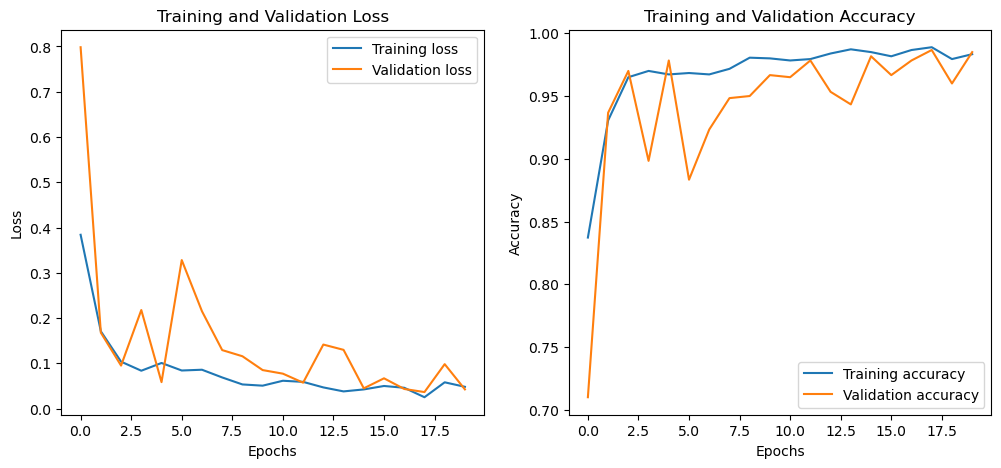

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### State Dictionary

In [31]:
# Retrieves the state dictionary (state_dict) of the model.
state_dict = model.state_dict()

# # Iterate and Print Layer Weights
# for layer_name, weights in state_dict.items():
#     print(f"Layer: {layer_name}")
#     print(f"Weight shape: {weights.size()}")
#     print(weights)
#     print("\n")

### Evaulate the Model
---

In [10]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store the true labels and predicted labels
true_labels = []
pred_labels = []

# Disable gradient computation
with torch.no_grad():
    # Gradients are not needed for evaluation, so this saves memory and computations.
    
    # Iterate over the test dataset
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Calculate classification accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Test set accuracy: {accuracy * 100:.2f}%')


Test set accuracy: 98.00%


### Data Visualization
---

### Sample Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


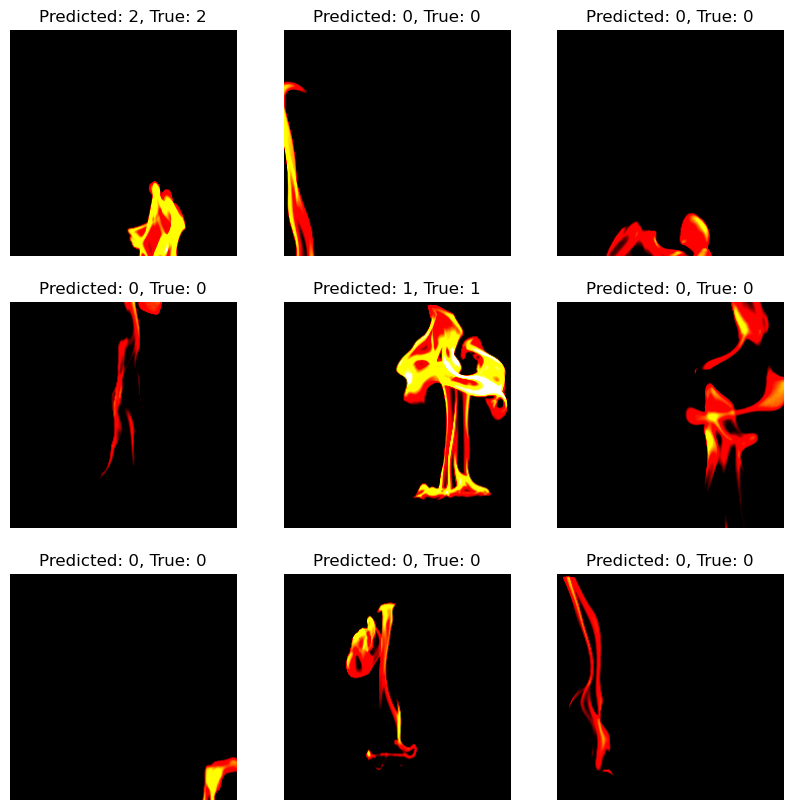

In [11]:
def sample_predictions(model, data_loader):
    model.eval()
    images, labels = next(iter(data_loader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying the first 9 images and their labels
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Rearranging the tensor dimensions to display the image
        plt.title(f'Predicted: {preds[i]}, True: {labels[i]}')
        plt.axis('off')
    plt.show()

sample_predictions(model, test_loader)


#### ROC Curve and AUC for Multi-class Classification

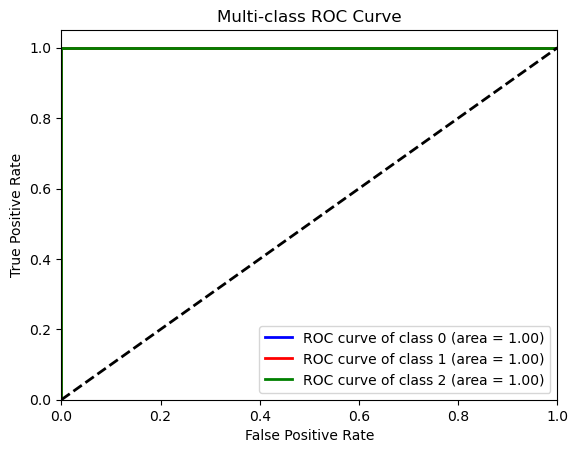

In [12]:
# Binarize the labels for multi-class ROC curve
y_test = label_binarize(labels, classes=[0, 1, 2])  # Assuming your classes are 0, 1, and 2
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


#### Histogram of Predicted Probabilities

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


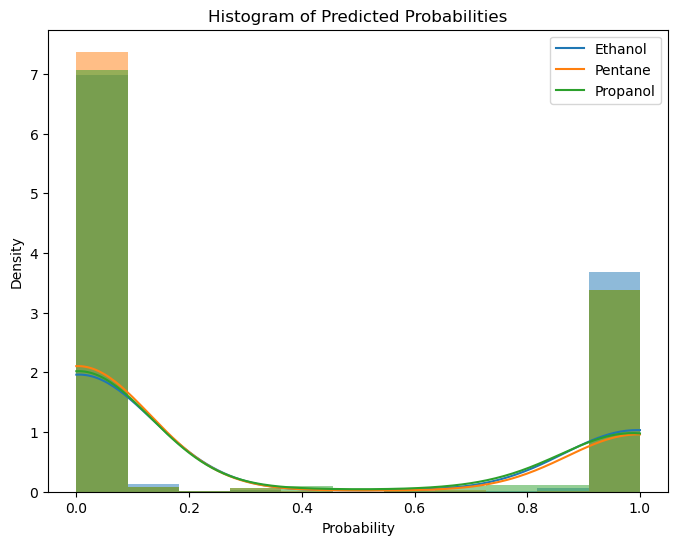

In [13]:
def histogram_of_predicted_probabilities(model, data_loader):
    model.eval()
    probabilities = torch.tensor([])

    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            probabilities = torch.cat((probabilities, F.softmax(outputs, dim=1).cpu()), dim=0)

    plt.figure(figsize=(8, 6))
    for i in range(probabilities.shape[1]):  # Assuming three classes
        sns.histplot(probabilities[:, i], kde=True, stat="density", linewidth=0)

    plt.title('Histogram of Predicted Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.legend(['Ethanol', 'Pentane', 'Propanol'])
    plt.show()

# Call the function
histogram_of_predicted_probabilities(model, test_loader)

#### Confusion Matrix

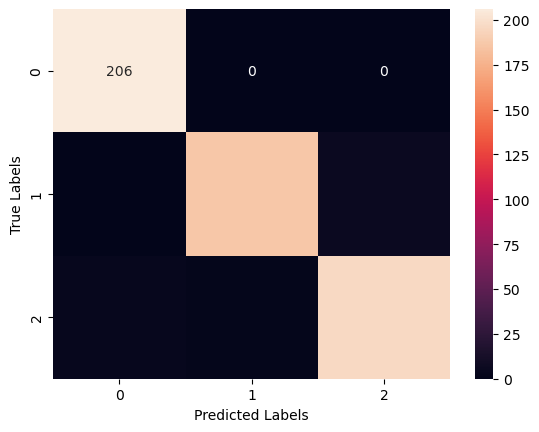

In [14]:
confusion_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Precision Recall Curve

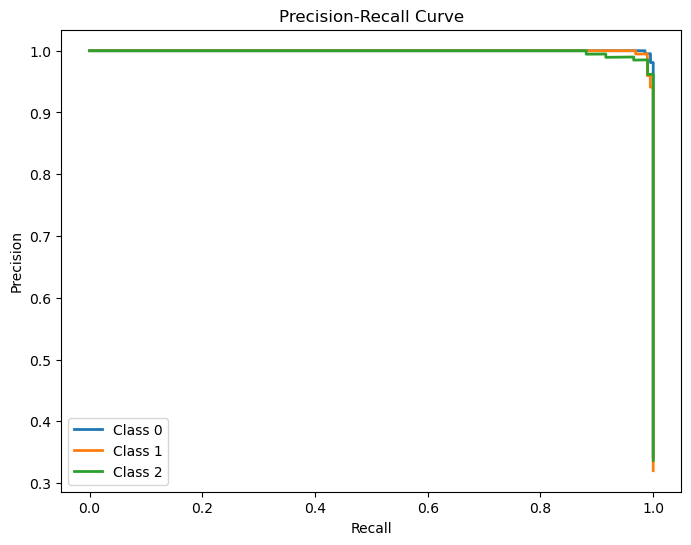

In [15]:
# Function to get probabilities from the model
def get_probabilities(model, loader):
    model.eval()  # Set the model to evaluation mode
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, _ in loader:
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
            all_probs.append(probs.cpu().numpy())  # Store probabilities

    return np.concatenate(all_probs, axis=0)  # Concatenate all probability arrays

# Get model probabilities for the test dataset
y_score = get_probabilities(model, test_loader)

# Binarize the labels
n_classes = 3  # Number of classes
y_test_binarized = label_binarize(true_labels, classes=[0, 1, 2])  # Convert labels to binary format

# Compute Precision-Recall for each class
precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    # Calculate precision and recall for each class

# Plotting the Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')
    # Plotting each class with a label

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.title('Precision-Recall Curve')
plt.show()


In [16]:
for i in range(n_classes):
    class_precision = precision_score(y_test_binarized[:, i], y_score[:, i].round())
    class_recall = recall_score(y_test_binarized[:, i], y_score[:, i].round())
    print(f'Class {i} - Precision: {class_precision:.2f}, Recall: {class_recall:.2f}')

Class 0 - Precision: 1.00, Recall: 0.99
Class 1 - Precision: 0.99, Recall: 0.98
Class 2 - Precision: 0.98, Recall: 0.99


#### Visualize the Feature (or Activation) Map
1. Each plot represents the activations captured by a different filter in the layer. These activations highlight different features of the image, like edges, textures, or patterns, depending on what each filter has learned to detect.

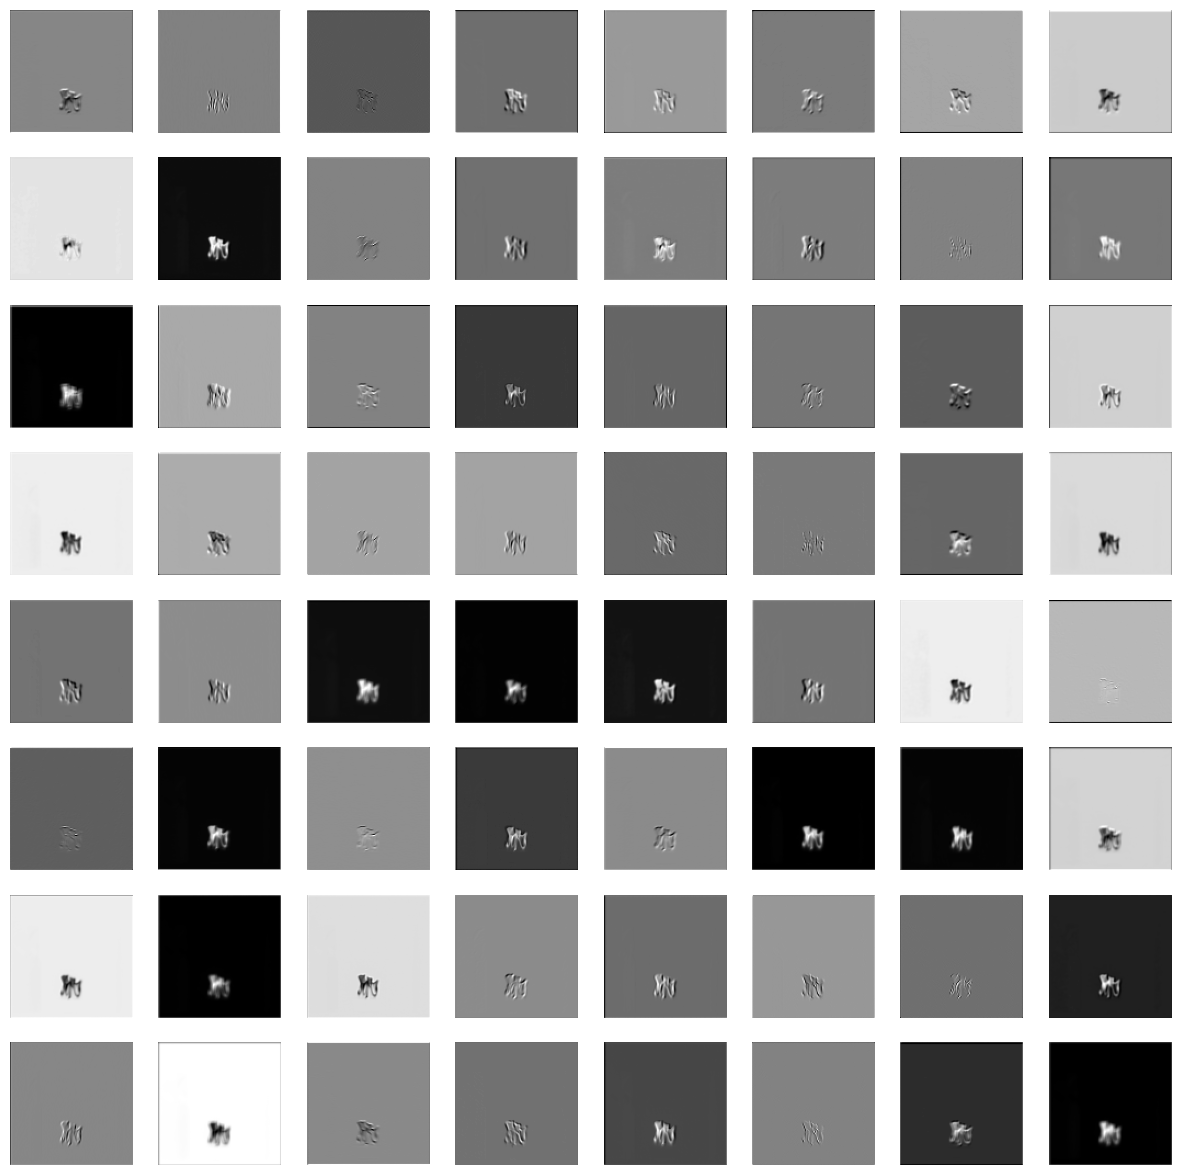

In [17]:
# Define the hook function
def visualize_hook(module, input, output):
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        plt.subplot(8, 8, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

# Choose a specific layer and register the hook
layer_to_visualize = model.conv1
hook = layer_to_visualize.register_forward_hook(visualize_hook)

# Load and transform an image from your dataset
image_path = './data/ethanol/Ethanol_Full_0001.jpg'
image = Image.open(image_path)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0)  # Add batch dimension

# Run the image through the model
_ = model(image)

# Remove the hook
hook.remove()


### Save and Load the fine-tuned Model

#### Save the Model

In [ ]:
# # Specify a path to save the model
# model_save_path = "./model"

# # Save the model state dictionary
# torch.save(model.state_dict(), model_save_path)

#### Load the Model

In [9]:
# Initialize a model instance
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# # Load the model
model.load_state_dict(torch.load('./model'))

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>